In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset

dataset = load_dataset("frgfm/imagenette",'160px',cache_dir='/mnt/d')

Lets look at the dataset

In [3]:
CLASSES = dataset['train'].features['label'].names
NUM_CLASSES = len(CLASSES)

## Transforms

In [16]:
from torchvision.transforms import v2

normalize = v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
size = 128
train_transform = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    v2.RandomRotation(degrees=15),
    v2.Resize(size*2),
    v2.CenterCrop(size),
    v2.ToTensor(),
    normalize,
])

test_transform = v2.Compose([
    v2.Resize(size+32),
    v2.CenterCrop(size),
    v2.ToTensor(),
    normalize,
])

/home/puneet/venv/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [17]:

def train_transforms(examples):
    examples["pixel_values"] = [train_transform(image.convert("RGB")) for image in examples["image"]]
    return examples


def test_transforms(examples):
    examples["pixel_values"] = [test_transform(image.convert("RGB")) for image in examples["image"]]
    return examples

dataset['train'].set_transform(train_transforms)
dataset['validation'].set_transform(test_transforms)


In [18]:
print('training length', len(dataset['train']))
print('validation length', len(dataset['validation']))

training length 9469
validation length 3925


## Modelling

In [19]:
from transformers import PretrainedConfig
from typing import List
from transformers import PreTrainedModel
from timm.models.resnet import BasicBlock, Bottleneck, ResNet
import torch
import timm


In [20]:
class ResNetConfig(PretrainedConfig):
    model_type='resnet'
    def __init__(self, model_name='resnet50d', **kwargs):
        self.model_name = model_name
        super().__init__(**kwargs)
        
class ResnetModelForImageClassification(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.model = timm.create_model(config.model_name,pretrained=False, num_classes=NUM_CLASSES)
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, pixel_values, labels=None):
        logits = self.model(pixel_values)
        if labels is not None:
            loss = self.criterion(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}
        

## Training

In [21]:
from transformers import TrainingArguments, Trainer

model_name = 'resnet'
batch_size = 256
args = TrainingArguments(
    f"{model_name}-finetuned-eurosat",
    remove_unused_columns=False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=0.001,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=30,
    warmup_ratio=0.1,
    logging_steps=1,
    max_grad_norm=0.1,
    weight_decay=0.05,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    dataloader_num_workers=8,
    fp16=True,
)


In [22]:
import numpy as np
import evaluate
metric = evaluate.load("accuracy")

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,

# and label_ids, which are the ground-truth labels as Numpy arrays.

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [23]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

### Callbacks

In [24]:
from utils import MixupCallback, CutMixCallback, LabelSmoothingCallback
from lr_finder import LearningRateFinderCallback

import matplotlib.pyplot as plt
from transformers import TrainerCallback, TrainingArguments
from torch.optim import lr_scheduler

from transformers.optimization import Adafactor, AdafactorSchedule
from torch.optim import lr_scheduler, AdamW
from transformers import EarlyStoppingCallback


### Trainer

#### Learning rate finder

In [98]:

resnetconfig = ResNetConfig()
model = ResnetModelForImageClassification(resnetconfig)

optimizer = AdamW(model.parameters(),  lr=1, eps=1e-08)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-7, total_iters=200)
#scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=20, epochs=10)


trainer = Trainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    optimizers=(optimizer, scheduler),
    callbacks=[  LearningRateFinderCallback()]
)

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy
1,2.694400,nan,0.099618
2,2.354600,nan,0.098599
3,3.348100,nan,0.098599
4,0.000000,nan,0.098599
5,0.000000,nan,0.098599


[0.005000099500000001, 0.010000099000000002, 0.015000098500000003, 0.020000098000000004, 0.020000098000000004, 0.025000097500000006, 0.030000097000000003, 0.03500009650000001, 0.04000009600000001, 0.04500009550000001, 0.050000095000000015, 0.05500009450000002, 0.060000094000000025, 0.06500009350000002, 0.07000009300000003, 0.07500009250000002, 0.08000009200000002, 0.08500009150000003, 0.09000009100000003, 0.09500009050000004, 0.10000009000000003, 0.10500008950000003, 0.11000008900000004, 0.11500008850000004, 0.12000008800000003, 0.12500008750000002, 0.13000008700000004, 0.13500008650000003, 0.14000008600000002, 0.14500008550000004, 0.15000008500000006, 0.15500008450000008, 0.1600000840000001, 0.1650000835000001, 0.17000008300000008, 0.17500008250000007, 0.18000008200000006, 0.18500008150000008, 0.19000008100000007, 0.19500008050000006, 0.20000008000000008, 0.2050000795000001, 0.2050000795000001, 0.2050000795000001, 0.2050000795000001, 0.2050000795000001, 0.21000007900000012, 0.21500007

<Figure size 1000x600 with 0 Axes>

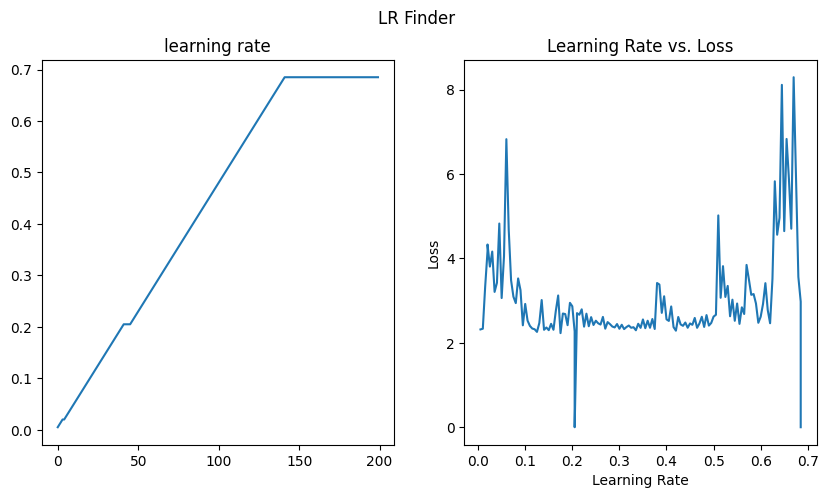

Learning rate finder complete. Please analyze the plot to select a suitable learning rate.


TrainOutput(global_step=200, training_loss=2.1038630747795106, metrics={'train_runtime': 42.1658, 'train_samples_per_second': 6736.97, 'train_steps_per_second': 26.325, 'total_flos': 0.0, 'train_loss': 2.1038630747795106, 'epoch': 5.405405405405405})

In [99]:
trainer.train()

#### Train

In [34]:
resnetconfig = ResNetConfig()
model = ResnetModelForImageClassification(resnetconfig)

optimizer = AdamW(model.parameters(),  lr=0.001, eps=1e-08)
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1e-7, total_iters=200)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=10, steps_per_epoch=28)

trainer = Trainer(
    model,
    args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['validation'],
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    optimizers=(optimizer, scheduler),
    callbacks=[ EarlyStoppingCallback(early_stopping_patience=5), LabelSmoothingCallback()]
)

In [35]:
size=128

In [36]:
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Accuracy
1,1.777700,3.947062,0.218089
2,1.632000,2.919278,0.280255
3,1.568100,1.811921,0.414013
4,1.201100,1.634535,0.465987
5,1.112300,1.365303,0.559490
6,0.806300,1.377385,0.572229
7,0.852700,1.151188,0.625987


ValueError: Tried to step 281 times. The specified number of total steps is 280

## Size = 256

In [ ]:
# refresh the callback

In [38]:
size=256

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.666000,3.131905,0.247134
2,1.179900,1.861571,0.395414
3,0.991500,1.364271,0.568408
4,0.873200,1.050813,0.652484
5,0.753300,0.882417,0.717452
6,0.644200,1.028910,0.678726


TrainOutput(global_step=222, training_loss=1.1074629366934836, metrics={'train_runtime': 45.3073, 'train_samples_per_second': 6269.854, 'train_steps_per_second': 24.499, 'total_flos': 0.0, 'train_loss': 1.1074629366934836, 'epoch': 6.0})

## Size = 512

In [39]:
size = 512

In [40]:
trainer.train()

ValueError: Tried to step 282 times. The specified number of total steps is 280

In [142]:
trainer.remove_callback(CutMixCallback)
trainer.add_callback(LabelSmoothingCallback())

## Evaluation

In [47]:
output = trainer.predict(dataset['validation'])

In [48]:
output.metrics

{'test_loss': 0.1004561185836792,
 'test_accuracy': 0.9681528662420382,
 'test_runtime': 1.4936,
 'test_samples_per_second': 2627.935,
 'test_steps_per_second': 10.713}